In [1]:
# Install packages
!pip install pennylane pennylane-lightning pennylane-lightning[gpu] cotengra quimb --upgrade
#!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.0/148.0 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 96.6 MB/s eta 0:00:00
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax
import time

import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable

jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp

import optax  # optimization using jax

import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
#torch.set_printoptions(profile="full")
import pennylane as qml
import pennylane.numpy as pnp

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile
%matplotlib inline

from jax.lib import xla_bridge

def set_jax_platform():
    # Check if TPU is available
    try:
        tpu_backend = xla_bridge.get_backend('tpu')
        if tpu_backend and tpu_backend.device_count() > 0:
            # Set platform to TPU
            jax.config.update('jax_platform_name', 'tpu')
            print("Set platform to TPU")
            return
    except RuntimeError:
        pass  # No TPU found, move on to check for GPU

    # Check if GPU is available
    try:
      gpu_backend = xla_bridge.get_backend('gpu')
      if gpu_backend and gpu_backend.device_count() > 0:
          # Set platform to CUDA (GPU)
          jax.config.update('jax_platform_name', 'gpu')
          print("Set platform to GPU")
    except RuntimeError:
          # Set platform to CPU
          jax.config.update('jax_platform_name', 'cpu')
          print("Set platform to CPU")

# Call the function to set the platform
set_jax_platform()

sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
prng = pnp.random.default_rng(seed=seed)
jrng_key = jax.random.PRNGKey(seed)

Set platform to GPU


# Prepare the Dataset

For the rescaled image matrix $M$, the "Hermitian version" of it can be calculated as:

$$
A = \frac{M+M^T}{2}
$$

In [3]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.view(-1)),
    torchvision.transforms.Lambda(lambda x: x / x.norm()),
])

train_dataset = torchvision.datasets.FashionMNIST(
    "FashioMNIST",
    train=True,
    download=True,
    transform=preprocess,
)
test_dataset = torchvision.datasets.FashionMNIST(
    "FashioMNIST",
    train=False,
    download=True,
    transform=preprocess,
)
dummy_trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)
dummy_testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True
)

dummy_x, dummy_y = next(iter(dummy_trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # 64x
print(dummy_y.shape)  # 64
print(dummy_y)
print(dummy_x[0,300:400])

100%|██████████| 26421880/26421880 [00:02<00:00, 10438104.48it/s]


Extracting FashioMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashioMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173580.08it/s]


Extracting FashioMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashioMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3267174.77it/s]


Extracting FashioMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashioMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5842066.29it/s]

Extracting FashioMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashioMNIST/FashionMNIST/raw

(64, 1024)
(64,)
[6 5 8 7 1 6 2 1 9 4 8 7 0 3 2 0 5 8 8 1 0 3 0 7 5 2 5 0 3 4 7 6 5 8 9 1 1
 3 6 4 4 7 9 3 5 4 0 7 1 7 2 2 4 0 5 8 5 7 4 0 1 2 0 3]
[0.04665674 0.04607353 0.04665674 0.04519872 0.04344909 0.04811477
 0.04607353 0.04723995 0.04723995 0.04694835 0.04869797 0.04607353
 0.05190562 0.03236812 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.0440323  0.04753156 0.0504476  0.05190562
 0.04432391 0.04723995 0.04665674 0.04694835 0.04694835 0.04811477
 0.04636514 0.04986439 0.04811477 0.04782316 0.04753156 0.04607353
 0.04753156 0.050156   0.05073921 0.04519872 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.04928118 0.04607353
 0.04753156 0.05919574 0.050156   0.05278044 0.05365526 0.05394686
 0.05365526 0.05569649 0.05423846 0.05423846 0.0

# Construct the QCNN

![QCNN architecture, linked from Pennylane.](https://pennylane.ai/_images/qcnn-architecture.png)

We will follow the code in the Pennylane demo [Generalization in QML from few training data](https://pennylane.ai/qml/demos/tutorial_learning_few_data/) to construct our QCNN layers.

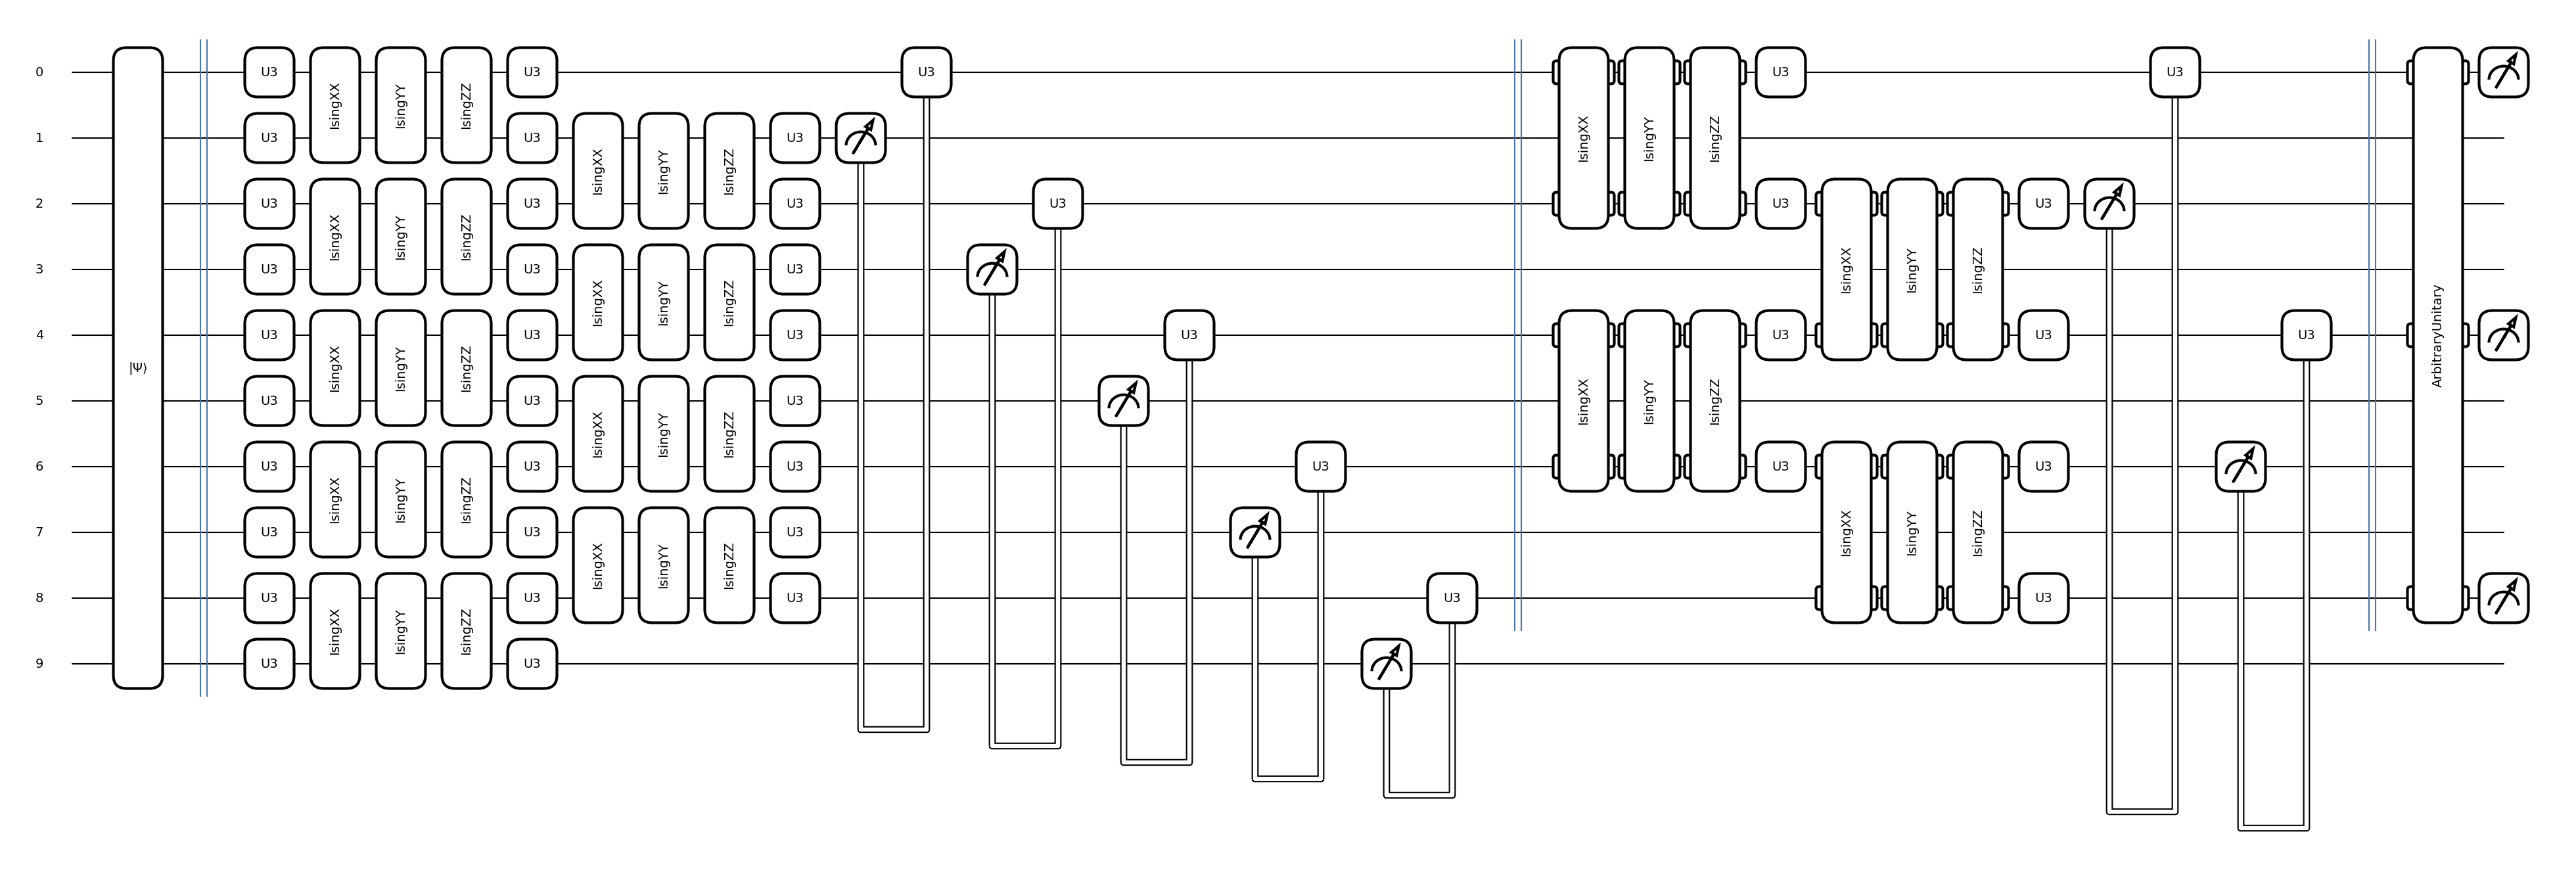

In [4]:
def convolutional_layer(weights, wires, skip_first_layer=True):
    """Adds a convolutional layer to a circuit.
    Args:
        weights (np.array): 1D array with 15 weights of the parametrized gates.
        wires (list[int]): Wires where the convolutional layer acts on.
        skip_first_layer (bool): Skips the first two U3 gates of a layer.
    """
    n_wires = len(wires)
    assert n_wires >= 3, "this circuit is too small!"

    for p in [0, 1]:
        for indx, w in enumerate(wires):
            if indx % 2 == p and indx < n_wires - 1:
                if indx % 2 == 0 and not skip_first_layer:
                    qml.U3(*weights[:3], wires=[w])
                    qml.U3(*weights[3:6], wires=[wires[indx + 1]])
                qml.IsingXX(weights[6], wires=[w, wires[indx + 1]])
                qml.IsingYY(weights[7], wires=[w, wires[indx + 1]])
                qml.IsingZZ(weights[8], wires=[w, wires[indx + 1]])
                qml.U3(*weights[9:12], wires=[w])
                qml.U3(*weights[12:], wires=[wires[indx + 1]])


def pooling_layer(weights, wires):
    """Adds a pooling layer to a circuit.
    Args:
        weights (np.array): Array with the weights of the conditional U3 gate.
        wires (list[int]): List of wires to apply the pooling layer on.
    """
    n_wires = len(wires)
    assert len(wires) >= 2, "this circuit is too small!"

    for indx, w in enumerate(wires):
        if indx % 2 == 1 and indx < n_wires:
            m_outcome = qml.measure(w)
            qml.cond(m_outcome, qml.U3)(*weights, wires=wires[indx - 1])

def conv_and_pooling(kernel_weights, n_wires, skip_first_layer=True):
    """Apply both the convolutional and pooling layer."""
    convolutional_layer(kernel_weights[:15], n_wires, skip_first_layer=skip_first_layer)
    pooling_layer(kernel_weights[15:], n_wires)


def dense_layer(weights, wires):
    """Apply an arbitrary unitary gate to a specified set of wires."""
    qml.ArbitraryUnitary(weights, wires)


num_wires = 10 # for 32 by 32 grey-scale images
device = qml.device("default.qubit", wires=num_wires)


@qml.qnode(device, interface="jax")
def conv_net(weights, last_layer_weights, features):
    """Define the QCNN circuit
    Args:
        weights (np.array): Parameters of the convolution and pool layers.
        last_layer_weights (np.array): Parameters of the last dense layer.
        features (np.array): Input data to be embedded using AmplitudEmbedding."""

    layers = weights.shape[1]
    wires = list(range(num_wires))

    # inputs the state input_state
    qml.AmplitudeEmbedding(features=features, wires=wires, pad_with=0.5)
    qml.Barrier(wires=wires, only_visual=True)

    # adds convolutional and pooling layers
    for j in range(layers):
        conv_and_pooling(weights[:, j], wires, skip_first_layer=(not j == 0))
        wires = wires[::2]
        qml.Barrier(wires=wires, only_visual=True)

    assert last_layer_weights.size == 4 ** (len(wires)) - 1, (
        "The size of the last layer weights vector is incorrect!"
        f" \n Expected {4 ** (len(wires)) - 1}, Given {last_layer_weights.size}"
    )
    dense_layer(last_layer_weights, wires)
    return qml.probs(wires=(0, 4, 8))


fig, ax = qml.draw_mpl(conv_net)(
    np.random.rand(18, 2), np.random.rand(4 ** 3 - 1), np.random.rand(2 ** num_wires)
)
plt.show()

# Training the QCNN with Flattened Image Data

In [5]:
@jax.jit
def compute_out(weights, weights_last, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    cost = lambda weights, weights_last, feature, label: conv_net(weights, weights_last, feature)
    return jax.vmap(cost, in_axes=(None, None, 0, 0), out_axes=0)(
        weights, weights_last, features, labels
    )


def compute_accuracy(weights, weights_last, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    pred = jnp.argmax(out, axis = 1)
    return jnp.sum(jnp.array(pred == labels).astype(int)) / len(out)


def compute_cost(weights, weights_last, features, labels):
    """Computes the cost over the provided features and labels"""
    logits = compute_out(weights, weights_last, features, labels)
    return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(logits, labels))


def init_weights():
    """Initializes random weights for the QCNN model."""
    weights = pnp.random.normal(loc=0, scale=1, size=(18, 2), requires_grad=True)
    weights_last = pnp.random.normal(loc=0, scale=1, size=4 ** 3 - 1, requires_grad=True)
    return jnp.array(weights), jnp.array(weights_last)


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0, 1]))

In [6]:
# select data
labels = [0,1,2,3,4,5,6,7]
indices_train = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]
indices_test = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]

N_TRAIN = len(indices_train)
N_TEST = len(indices_test)

print(
    f"Training with: {N_TRAIN}; Testing with: {N_TEST}"
)

def train_qcnn(batchsize:int, n_epochs:int, seed:int = 1701):

    start = time.time()
    pnp.random.seed(seed)
    np.random.seed(seed)
    # load data
    labels = [0,1,2,3,4,5,6,7]
    indices_train = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]
    indices_test = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]
    trainloader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dataset, indices_train), batch_size=batchsize, shuffle=True
)
    testloader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_dataset, indices_test), batch_size=batchsize, shuffle=True
)

    # init weights and optimizer
    weights, weights_last = init_weights()

    # learning rate decay
    cosine_decay_scheduler = optax.cosine_decay_schedule(0.1, decay_steps=n_epochs, alpha=0.95)
    optimizer = optax.adam(
        learning_rate=cosine_decay_scheduler,
        #b1=0.5,
        #b2=0.99999,
        #eps=1e-08,
        )
    opt_state = optimizer.init((weights, weights_last))

    # data containers
    train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []

    for step in range(n_epochs):
        train_cost_batches = []
        train_acc_batches = []
        test_cost_batches = []
        test_acc_batches = []
        epoch_start = time.time()
        print(f"Training at Epoch {step+1}/{n_epochs}, Train size {len(trainloader)}, Test size {len(testloader)}......")
        for batch, (x_train, y_train) in enumerate(trainloader):
          batch_start = time.time()
          # Training step with (adam) optimizer
          x_train, y_train = jnp.asarray(x_train.numpy()), jnp.asarray(y_train.numpy())
          train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
          updates, opt_state = optimizer.update(grad_circuit, opt_state)
          weights, weights_last = optax.apply_updates((weights, weights_last), updates)
          train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
          train_cost_batches.append(train_cost)
          train_acc_batches.append(train_acc)
          print(f"Training at Epoch {step+1}/{n_epochs}, Batch {batch+1}, Cost {train_cost}, Acc {train_acc}. Time {time.time()-batch_start}")


        train_cost_epochs.append(np.mean(train_cost_batches))
        train_acc_epochs.append(np.mean(train_acc_batches))


        # load test data
        for batch, (x_test, y_test) in enumerate(testloader):
          batch_start = time.time()
          x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())
          # compute accuracy and cost on testing data
          test_out = compute_out(weights, weights_last, x_test, y_test)
          test_pred = jnp.argmax(test_out, axis=1)
          test_acc = jnp.sum(jnp.array(test_pred == y_test).astype(int)) / len(test_out)
          test_cost = jnp.mean(optax.softmax_cross_entropy_with_integer_labels(test_out, y_test))
          test_cost_batches.append(test_cost)
          test_acc_batches.append(test_acc)
          print(f"Testing at Epoch {step+1}/{n_epochs}, Batch {batch+1}, Cost {test_cost}, Acc {test_acc}. Time {time.time()-batch_start}")
        test_acc_epochs.append(np.mean(test_acc_batches))
        test_cost = np.mean(test_cost_batches)
        test_cost_epochs.append(test_cost)
        print("......")
        print(f"Epoch {step+1}/{n_epochs}, Train: Cost {np.mean(train_cost_batches)}, Acc {np.mean(train_acc_batches)}")
        print(f"Epoch {step+1}/{n_epochs}, Test: Cost {test_cost}, Acc {test_acc}. Time {time.time()-epoch_start}")
        print("=-="*10)

    return dict(
        n_train=[N_TRAIN] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int).tolist(),
        train_cost=[c.astype(float) for c in train_cost_epochs],
        train_acc=[c.astype(float) for c in train_acc_epochs],
        test_cost=[c.astype(float) for c in test_cost_epochs],
        test_acc=[c.astype(float) for c in test_acc_epochs],
    )

Training with: 48000; Testing with: 8000


In [7]:
n_epochs = 100
n_reps = 5
batch_size = 10000

train_sizes = [N_TRAIN]

def run_iterations():
    results_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
    )

    for _ in range(n_reps):
        results = train_qcnn(n_epochs=n_epochs, batchsize=batch_size)
        results_df = pd.concat(
            [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
        )

    return results_df

results_df = run_iterations()

Streaming output truncated to the last 5000 lines.
Training at Epoch 46/100, Batch 5, Cost 1.9755266209470395, Acc 0.388125. Time 0.4645206928253174
Testing at Epoch 46/100, Batch 1, Cost 1.9767750226381227, Acc 0.385375. Time 0.12089157104492188
......
Epoch 46/100, Train: Cost 1.9763379615453651, Acc 0.38686499999999996
Epoch 46/100, Test: Cost 1.9767750226381227, Acc 0.385375. Time 13.071369171142578
=-==-==-==-==-==-==-==-==-==-=
Training at Epoch 47/100, Train size 5, Test size 1......
Training at Epoch 47/100, Batch 1, Cost 1.9758249011772038, Acc 0.3833. Time 0.6091105937957764
Training at Epoch 47/100, Batch 2, Cost 1.9758407230679558, Acc 0.3892. Time 0.6448979377746582
Training at Epoch 47/100, Batch 3, Cost 1.9775569003609268, Acc 0.3859. Time 0.641829252243042
Training at Epoch 47/100, Batch 4, Cost 1.9754615266691213, Acc 0.3886. Time 0.6331024169921875
Training at Epoch 47/100, Batch 5, Cost 1.9769386843067804, Acc 0.386125. Time 0.46488165855407715
Testing at Epoch 47/10

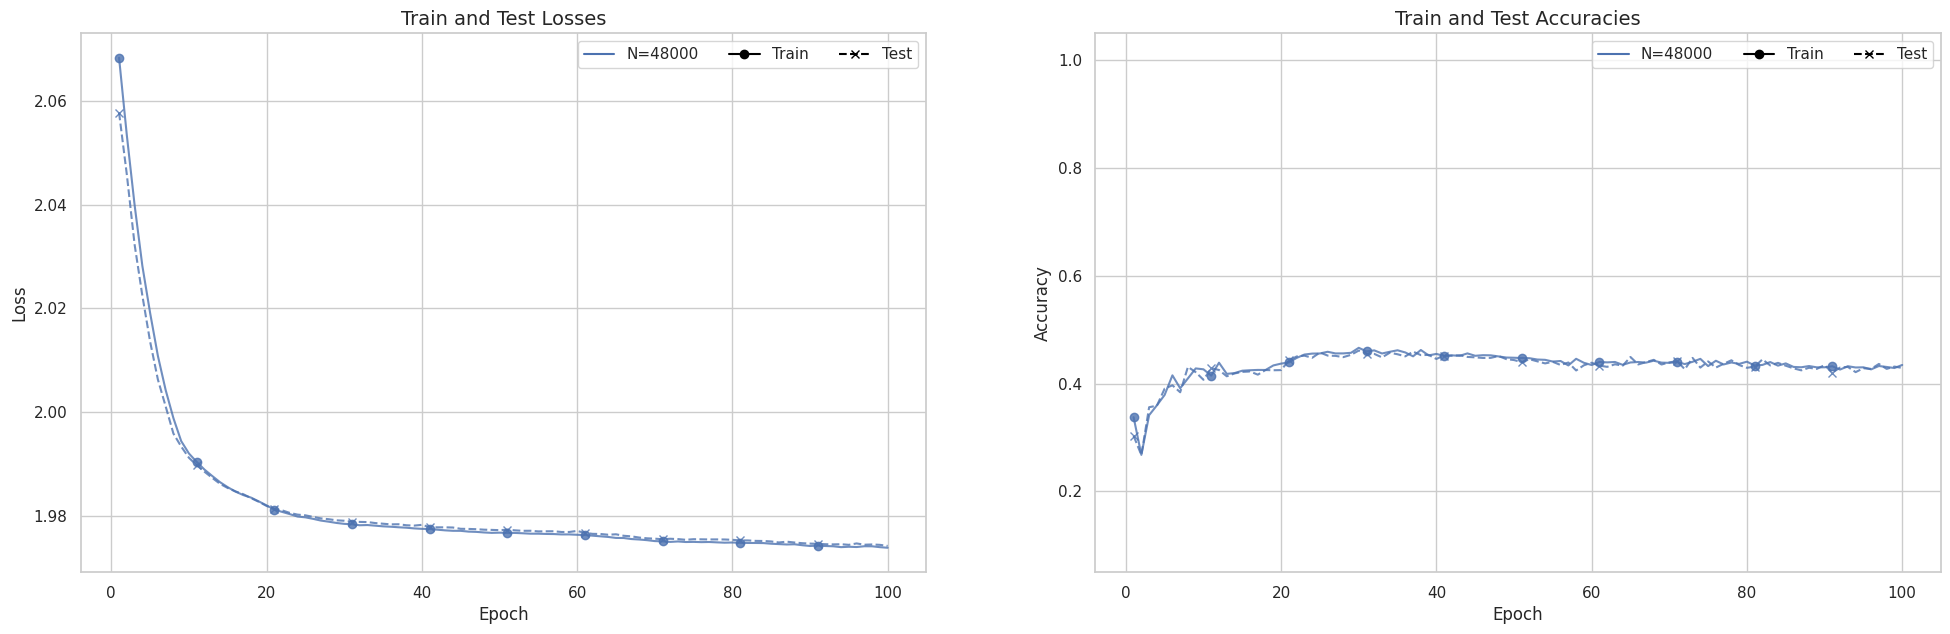

In [8]:
# aggregate dataframe
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"])
df_agg = df_agg.reset_index()

sns.set_style('whitegrid')
colors = sns.color_palette()
fig, axes = plt.subplots(ncols=2, figsize=(24, 7))

generalization_errors = []

# plot losses and accuracies
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train]

    dfs = [df.train_cost["mean"], df.test_cost["mean"], df.train_acc["mean"], df.test_acc["mean"]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0,0,1,1]

    for k in range(4):
        ax = axes[axs[k]]
        ax.plot(df.step, dfs[k], lines[k], label=labels[k], markevery=10, color=colors[i], alpha=0.8)


    # plot final loss difference
    #dif = df[df.step == n_epochs].test_cost["mean"] - df[df.step == n_epochs].train_cost["mean"]
    #generalization_errors.append(dif)

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# format generalization error plot
#ax = axes[1]
#ax.plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
#ax.set_xscale('log')
#ax.set_xticks(train_sizes)
#ax.set_xticklabels(train_sizes)
#ax.set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
#ax.set_xlabel('Training Set Size')

# format loss plot
ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.05, 1.05)

legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
    ] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]

axes[0].legend(handles=legend_elements, ncol=3)
axes[1].legend(handles=legend_elements, ncol=3)

#axes[1].set_yscale('log', base=2)
plt.show()

In [9]:
save_folder = "/content/drive/MyDrive/Research/HermtianEncodingImg/fashion-mnist"
results_df.to_csv(os.path.join(save_folder, "fashion-mnist_baseline_results.csv"))
df_agg.to_csv(os.path.join(save_folder, "fashion-mnist_baseline_results_agg.csv"))
# save the plot to file
fig.savefig(os.path.join(save_folder, "fashion-mnist_baseline_results.pdf"))